# Stable Diffusion Pipeline

In [1]:
!pip install -Uq diffusers transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.4 MB/s eta 0:00:00


In [2]:
from transformers import CLIPTextModel, CLIPTokenizer
import torch

In [3]:
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14', torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14', torch_dtype=torch.float16).to('cuda')

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [4]:
from diffusers import AutoencoderKL, UNet2DConditionModel

In [5]:
vae = AutoencoderKL.from_pretrained('stabilityai/sd-vae-ft-ema', torch_dtype=torch.float16, low_cpu_mem_usage=False).to('cuda')
unet = UNet2DConditionModel.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder='unet', torch_dtype=torch.float16, low_cpu_mem_usage=False).to('cuda')

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [6]:
prompt = ['a photograph of a mansion by the seaside, 4K, high quality, high resolution']
height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

In [7]:
text_input = tokenizer(prompt, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors='pt')
text_input['input_ids']

tensor([[49406,   320,  8853,   539,   320, 13404,   638,   518, 18867,   267,
           275,   330,   267,  1400,  3027,   267,  1400,  9977, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]])

In [8]:
print(tokenizer.decode(49406), tokenizer.decode(49407), tokenizer.decode(1929))

<|startoftext|> <|endoftext|> dog


In [9]:
text_input['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])

In [10]:
text_embeddings = text_encoder(text_input.input_ids.to('cuda'))[0].half()
text_embeddings.shape

torch.Size([1, 77, 768])

In [11]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([''] * batch_size, padding='max_length', max_length=max_length, return_tensors='pt')
uncond_embeddings = text_encoder(uncond_input.input_ids.to('cuda'))[0].half()
uncond_embeddings.shape

torch.Size([1, 77, 768])

In [12]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [13]:
torch.manual_seed(1337)
latents = torch.randn((batch_size, unet.config.in_channels, height//8, width//8))
latents = latents.to('cuda').half()
latents.shape

torch.Size([1, 4, 64, 64])

In [14]:
from diffusers import LMSDiscreteScheduler

In [15]:
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')

In [16]:
scheduler.set_timesteps(num_inference_steps)

In [17]:
latents = latents * scheduler.init_noise_sigma

In [18]:
import matplotlib.pyplot as plt

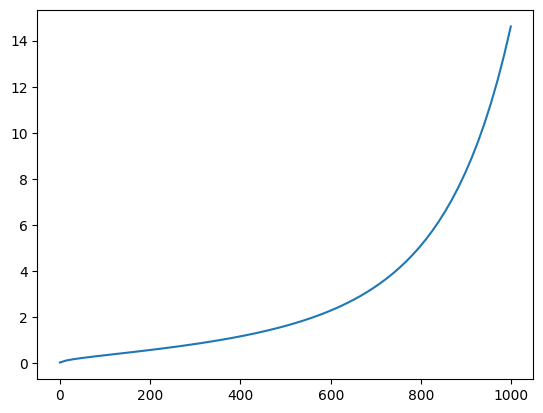

In [19]:
plt.plot(scheduler.timesteps, scheduler.sigmas[:-1])

In [20]:
from tqdm.auto import tqdm

In [21]:
for i, t in enumerate(tqdm(scheduler.timesteps)):
  input = torch.cat([latents] * 2)
  input = scheduler.scale_model_input(input, t)

  with torch.no_grad():
    pred = unet(input, t, encoder_hidden_states=text_embeddings).sample

  pred_uncond, pred_text = pred.chunk(2)
  pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

  latents = scheduler.step(pred, t, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

In [22]:
with torch.no_grad():
  image = vae.decode(1/.18215 * latents).sample

In [23]:
from PIL import Image

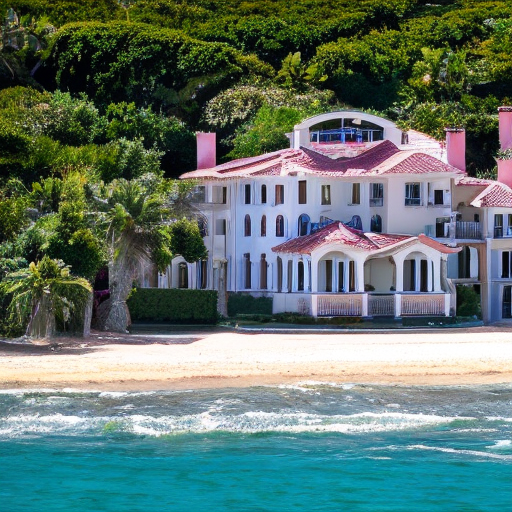

In [24]:
image = (image/2+.5).clamp(0, 1)
image = image[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image*255).round().astype('uint8')
Image.fromarray(image)